In [513]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [514]:
# choosing ticker symbols (U.S. stocks of tech sector)
tickers = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NFLX', 'TSLA']

# downloading 10 years of closing stock prices adjusted for coporate actions
data = yf.download(tickers, start="2015-01-01", end="2024-12-31", auto_adjust=True)['Close']

[*********************100%***********************]  8 of 8 completed


In [515]:
data.shape

(2515, 8)

In [516]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2515 non-null   float64
 1   AMZN    2515 non-null   float64
 2   GOOG    2515 non-null   float64
 3   GOOGL   2515 non-null   float64
 4   META    2515 non-null   float64
 5   MSFT    2515 non-null   float64
 6   NFLX    2515 non-null   float64
 7   TSLA    2515 non-null   float64
dtypes: float64(8)
memory usage: 176.8 KB


In [517]:
data.head()

Ticker,AAPL,AMZN,GOOG,GOOGL,META,MSFT,NFLX,TSLA
Date,,,,,,,,
2015-01-02,24.288576,15.4260,26.014023,26.319653,78.021965,39.998707,49.848572,14.620667
2015-01-05,23.604340,15.1095,25.471743,25.818159,76.768845,39.630882,47.311428,14.006000
2015-01-06,23.606552,14.7645,24.881382,25.180983,75.734528,39.049202,46.501431,14.085333
2015-01-07,23.937574,14.9210,24.838757,25.106926,75.734528,39.545341,46.742859,14.063333
2015-01-08,24.857307,15.0230,24.917072,25.194403,77.753448,40.708683,47.779999,14.041333


In [518]:
returns = data.pct_change().dropna()   # daily returns
returns.head()

Ticker,AAPL,AMZN,GOOG,GOOGL,META,MSFT,NFLX,TSLA
Date,,,,,,,,
2015-01-05,-0.028171,-0.020517,-0.020846,-0.019054,-0.016061,-0.009196,-0.050897,-0.042041
2015-01-06,0.000094,-0.022833,-0.023177,-0.024679,-0.013473,-0.014677,-0.017121,0.005664
2015-01-07,0.014022,0.010600,-0.001713,-0.002941,0.000000,0.012705,0.005192,-0.001562
2015-01-08,0.038422,0.006836,0.003153,0.003484,0.026658,0.029418,0.022188,-0.001564
2015-01-09,0.001072,-0.011749,-0.012951,-0.012211,-0.005628,-0.008405,-0.015458,-0.018802


In [519]:
mean_returns = returns.mean()   # average of daily returns of each stock
mean_returns

Ticker
AAPL     0.001091
AMZN     0.001272
GOOG     0.000957
GOOGL    0.000949
META     0.001087
MSFT     0.001085
NFLX     0.001535
TSLA     0.001979
dtype: float64

In [520]:
cov_matrix = returns.cov()      # to get how much the stocks move together (risk analysis)
cov_matrix

Ticker,AAPL,AMZN,GOOG,GOOGL,META,MSFT,NFLX,TSLA
Ticker,,,,,,,,
AAPL,0.000322,0.000205,0.000194,0.000194,0.000223,0.000209,0.000207,0.000270
AMZN,0.000205,0.000427,0.000240,0.000239,0.000288,0.000232,0.000292,0.000288
GOOG,0.000194,0.000240,0.000322,0.000320,0.000266,0.000219,0.000224,0.000235
GOOGL,0.000194,0.000239,0.000320,0.000322,0.000266,0.000219,0.000223,0.000235
META,0.000223,0.000288,0.000266,0.000266,0.000558,0.000236,0.000294,0.000272
MSFT,0.000209,0.000232,0.000219,0.000219,0.000236,0.000292,0.000218,0.000246
NFLX,0.000207,0.000292,0.000224,0.000223,0.000294,0.000218,0.000756,0.000330
TSLA,0.000270,0.000288,0.000235,0.000235,0.000272,0.000246,0.000330,0.001297


In [521]:
# calculating the working days every year
business_days_per_year = data.index.to_series().dt.year.value_counts().sort_index()
average_business_days = int(math.ceil(business_days_per_year.mean()))

print(business_days_per_year)
print(f"\nAverage business days per year: {average_business_days}")  

Date
2015    252
2016    252
2017    251
2018    251
2019    252
2020    253
2021    252
2022    251
2023    250
2024    251
Name: count, dtype: int64

Average business days per year: 252


In [522]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):  

    annual_return = np.dot(weights, mean_returns) * 252  # no. of business days in a year

    annual_volatility = np.sqrt( np.dot (weights.T, np.dot (cov_matrix * 252, weights) ) )  

    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    
    return annual_return, annual_volatility, sharpe_ratio


In [523]:
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):

    ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)

    return -sharpe

In [524]:
def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.01):
    
    num_assets = len(mean_returns)

    bounds = tuple((0, 1) for _ in range(num_assets))

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    init_guess = num_assets * [1. / num_assets]   # equal weighting

    result = minimize(negative_sharpe, init_guess,
                      args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [525]:
opt_result = optimize_portfolio(mean_returns, cov_matrix)
opt_weights = opt_result.x

opt_ret, opt_vol, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)


In [526]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.01):
    results = {'returns': [], 'volatility': [], 'sharpe': [], 'weights': []}
    num_assets = len(mean_returns)

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)     # normalization

        ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)

        results['returns'].append(ret)
        results['volatility'].append(vol)
        results['sharpe'].append(sharpe)
        results['weights'].append(weights)

    return pd.DataFrame(results)

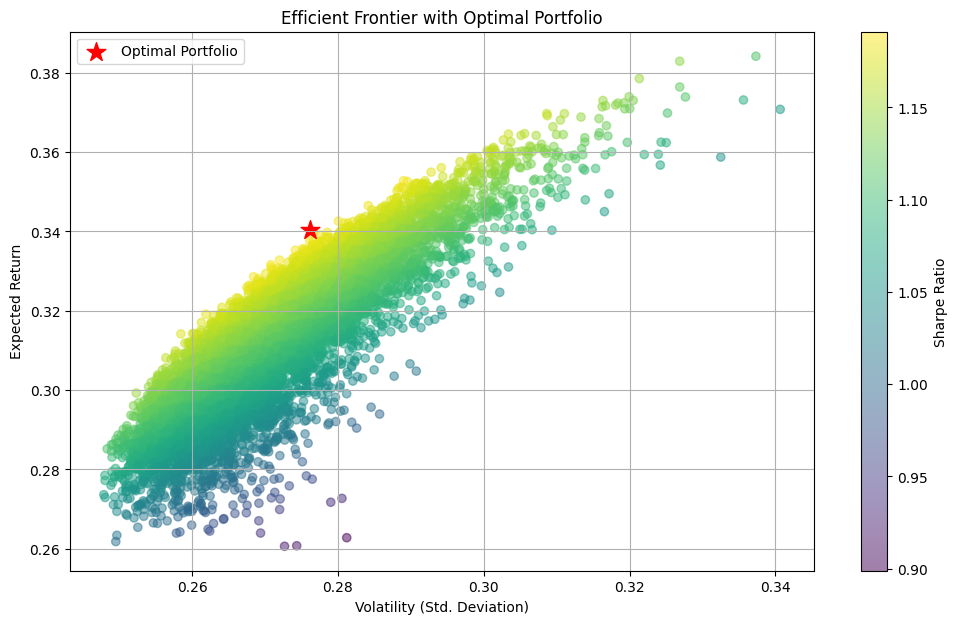

In [527]:
portfolios = simulate_random_portfolios(10000, mean_returns, cov_matrix)

# plotting the results
plt.figure(figsize=(12, 7))
plt.scatter(portfolios['volatility'], portfolios['returns'], c=portfolios['sharpe'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_ret, marker='*', color='r', s=200, label='Optimal Portfolio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio')
plt.grid(True)
plt.show()


In [528]:
print("Optimal Portfolio Allocation\n")
for ticker, weight in zip(tickers, opt_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\nExpected Annual Return: {opt_ret:.2%}")
print(f"Annual Volatility: {opt_vol:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")


Optimal Portfolio Allocation

AAPL: 22.08%
AMZN: 19.69%
GOOG: 0.00%
GOOGL: 0.00%
META: 0.00%
MSFT: 23.82%
NFLX: 17.97%
TSLA: 16.44%

Expected Annual Return: 34.05%
Annual Volatility: 27.62%
Sharpe Ratio: 1.20
